## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Analysis and Discussion](#analysis)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

   Mixed martial arts is often an unpredictable sport, with many factors which go into deciding who will be the winner of any given bout.The very nature of the sport is choatic, and often, maxims such as the transitive property, do not hold, that is if fighter 'A' beat fight 'B', who beat fighter 'C', does not necessarily mean Fighter 'C' will beat fighter A (to see some practical examples see [here](https://www.mma-math.com/))
   
   It is often held, that having a longer reach is an adavantage and increases ones chances of winning, in this small project, we will use data science methods to determine if this holds true. 



In [39]:
#import libraries needed 
# Web Scraping
from bs4 import BeautifulSoup
import requests

# Data Cleaning
import numpy as np
import pandas as pd

# Visualisation
import seaborn as sns
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(['ggplot'])

# Statistical Analysis
import scipy
from scipy import stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot

# Miscellaneous
import string
import time
print('libraries imported')

libraries imported


## Data <a name="data"></a>

The data we will be using is statistics scraped from http://ufcstats.com/statistics/fighters. First we will scrape the data and store it into a dictionary. 

In [2]:
#scrape the data and store it in a dictionary
alphabet = string.ascii_lowercase

fighter_stats = {}

for letter in alphabet: 
    link = requests.get(f"http://www.ufcstats.com/statistics/fighters?char={letter}&page=all")
    soup = BeautifulSoup(link.text, "lxml")
    fighter_stats[letter] = soup.find_all("td", {'class':'b-statistics__table-col'})
    
print("done")


done


Next we will create lists for each of the stats that we need, omitting the ones that are not required.

In [3]:
fighter_first_names = []

for key, value in fighter_stats.items():
    for fighter in np.arange(0, len(fighter_stats[key]), 11):
        fighter_first_name = value[fighter].text.split("\n")[1]
        fighter_first_names.append(fighter_first_name)
    

In [4]:
fighter_last_names = []

for key, value in fighter_stats.items():
    for fighter in np.arange(1, len(fighter_stats[key]) + 1, 11):
        fighter_last_name = value[fighter].text.split("\n")[1]
        fighter_last_names.append(fighter_last_name)

In [5]:
fighter_reaches = []

for key, value in fighter_stats.items():
    for fighter in np.arange(5, len(fighter_stats[key]) + 5, 11):
        fighter_reach = value[fighter].text.split("\n")[1][10:14]
        fighter_reaches.append(fighter_reach)

In [8]:
fighter_wins = []

for key, value in fighter_stats.items():
    for fighter in np.arange(7, len(fighter_stats[key]) + 7, 11):
        fighter_win = value[fighter].text.split("\n")[1][10:]
        fighter_wins.append(fighter_win)

In [10]:
fighter_losses = []

for key, value in fighter_stats.items():
    for fighter in np.arange(8, len(fighter_stats[key]) + 8, 11):
        fighter_loss = value[fighter].text.split("\n")[1][10:]
        fighter_losses.append(fighter_loss)

In [11]:
fighter_draws = []

for key, value in fighter_stats.items():
    for fighter in np.arange(9, len(fighter_stats[key]) + 9, 11):
        fighter_draw = value[fighter].text.split("\n")[1][10:]
        fighter_draws.append(fighter_draw)


The next step is to create the data frame, and clean the data by dropping any cells with missing reachs, and making sure the numerical data is either an integer or a float.

In [12]:
f_df = pd.DataFrame(fighter_first_names)
f_df.rename(columns={0:"first name"}, inplace = True)

f_df["last name"] = fighter_last_names
f_df["reach"] = fighter_reaches
f_df["wins"] = fighter_wins
f_df["losses"] = fighter_losses
f_df["draws"] = fighter_draws

f_df.head()



,first name,last name,reach,wins,losses,draws
0,Tom,Aaron,--,5,3,0
1,Danny,Abbadi,--,4,6,0
2,David,Abbott,--,10,15,0
3,Shamil,Abdurakhimov,76.0,20,5,0
4,Hiroyuki,Abe,--,8,15,3


In [13]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559 entries, 0 to 3558
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   first name  3559 non-null   object
 1   last name   3559 non-null   object
 2   reach       3559 non-null   object
 3   wins        3559 non-null   object
 4   losses      3559 non-null   object
 5   draws       3559 non-null   object
dtypes: object(6)
memory usage: 167.0+ KB


In [14]:
#drop all the fighters with missing reaches
f_df = f_df[f_df["reach"] != '--']
f_df.head()

,first name,last name,reach,wins,losses,draws
3,Shamil,Abdurakhimov,76.0,20,5,0
5,Daichi,Abe,71.0,6,2,0
8,Klidson,Abreu,74.0,15,5,0
11,Juan,Adams,80.0,5,3,0
12,Anthony,Adams,76.0,8,2,0


In [15]:
f_df["wins"] = f_df["wins"].astype(int)
f_df["losses"] = f_df["losses"].astype(int)
f_df["draws"] = f_df["draws"].astype(int)
f_df["reach"] = f_df['reach'].astype(float)
f_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1631 entries, 3 to 3558
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   first name  1631 non-null   object 
 1   last name   1631 non-null   object 
 2   reach       1631 non-null   float64
 3   wins        1631 non-null   int32  
 4   losses      1631 non-null   int32  
 5   draws       1631 non-null   int32  
dtypes: float64(1), int32(3), object(2)
memory usage: 70.1+ KB


Next we shall calculate the win ratio, by calculating total fights, and dividing wins by total fights

In [16]:
#calculate total figths and win ratio
f_df["total_fights"] = f_df.wins + f_df.losses + f_df.draws 
f_df["win_ratio"] = round(f_df.wins/f_df.total_fights, 2)

f_df.head()


,first name,last name,reach,wins,losses,draws,total_fights,win_ratio
3,Shamil,Abdurakhimov,76.0,20,5,0,25,0.80
5,Daichi,Abe,71.0,6,2,0,8,0.75
8,Klidson,Abreu,74.0,15,5,0,20,0.75
11,Juan,Adams,80.0,5,3,0,8,0.62
12,Anthony,Adams,76.0,8,2,0,10,0.80


In [17]:
print(f'number of fighters: {len(f_df)}')

number of fighters: 1631


In [18]:
print(f'number of fighters: {len(f_df)}')

number of fighters: 1631


## Analysis and Discussion <a name="analysis"></a>

Before we can conduct any analysis, we must determine if the data is [normally distrubuted](https://en.wikipedia.org/wiki/Normal_distribution) or not, this helps us in choosing which method to use in our analysis. There are many methods to determine this, here I will use a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) of the residuals, which plots the theoretical quantiles, which are normally distrubuted  against the sample quantiles. The more linear the graph, the closer to the normal distribution the data is. 

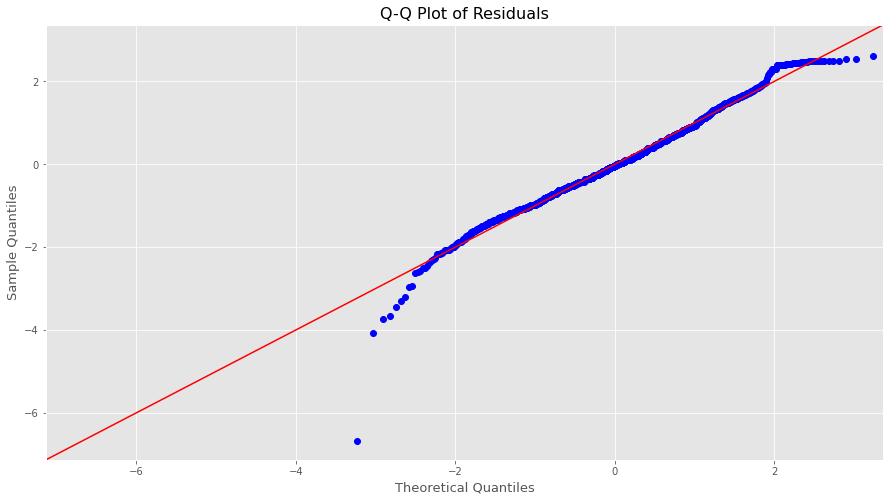

In [19]:
stance_model = ols("win_ratio ~ C(reach)", data=f_df).fit()
residuals = stance_model.resid

fig = qqplot(residuals, line='45', fit=True)

ax = plt.gca()
fig.set_size_inches(15, 8)
ax.set_xlabel("Theoretical Quantiles", fontsize=13)
ax.set_ylabel("Sample Quantiles", fontsize=13)
ax.set_title("Q-Q Plot of Residuals", fontsize=16)
plt.show()

As we can see from the graph is fairly linear, which means it is close to normal distrbution

To test if there is a linear correlation, that is if reach increases, win ratio increases, we will use the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which falls between -1 and 1, with -1 being a strong negetive correlation, 1 being a strong positive correlation, and 0 being no correlation. 

In [38]:
x = f_df['reach']
y=f_df['win_ratio']
r,p =scipy.stats.pearsonr(x, y)
print('Pearsons correlation: %.4f' % r)
#print(r)

Pearsons correlation: 0.0896


As we can see from the above, there is a very weak positive relationship between the two, as .0896 is closer to 0 then it is to 1. 

Another measure we can use to measure the strength of the relationship is the [Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), also referred to as R<sup>2</sup>  which can tell us how much of the variance in the dependant variable(win ratio) is explained by the variation in the independant variable(reach). This gives us a more precise intrepration then the correlation above.

In [43]:
x = f_df['reach']
y=f_df['win_ratio']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print('The Coefficient of determination is:%f' % r_value**2)

The Coefficient of determination is:0.008024


From the above we can see that only .8% of the variation in win ratio is explained by the variation in reach, 99.2% remains unexplained.

Finally, let's plot the two variables to visualize this data.

Text(0.5, 1.0, 'Win Ratio vs Reach')

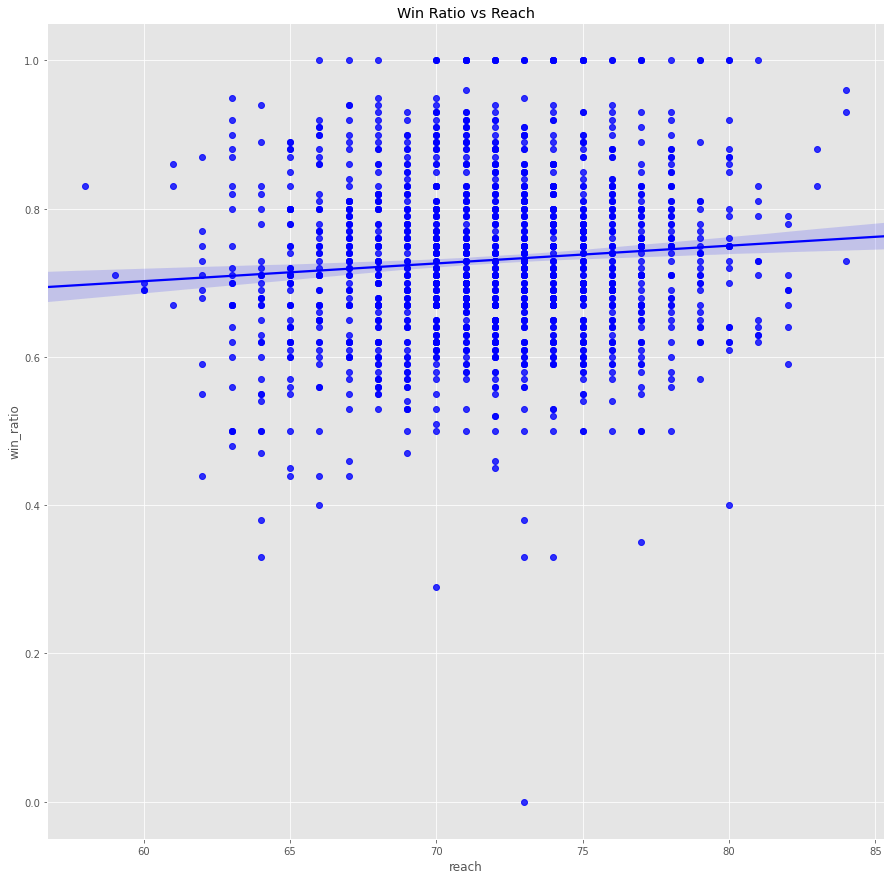

In [23]:
plt.figure(figsize=(15, 15))
ax= sns.regplot(x='reach', y ='win_ratio', data=f_df, color = 'blue')
ax.set_title('Win Ratio vs Reach')

## Conclusion <a name="conclusion"></a>

   From the above analysis, we can conclude that reach has little to no effect on the outcome of a fight, based on the weak correlation between reach and win ratio and the very low R<sup>2</sup>, calculated above, as well as observing the plot. One should keep in mind, the sample size here was small, a a large sample size  is prefered because it would reduce the role of chance in the findings. Only UFC fighters were taken into consideration, and the sample size  could be  expanded to Bellator, One, and other promotions, and/or include boxers, kickboxers and Muay Thai fighters, and perhaps test if there it is a difference between combat sports. 
  
 
  